In [4]:
import pyemu
import flopy as fp
from flopy.utils import Raster
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys


sys.path.append("../../modules")
# hand made functions
from Rouss import *

In [5]:
t_d ="master_glm"
case = "2D_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

type transform  count           initial value  \
cond                        cond       log      6    0.058434 to 0.081852   
irr__multiplier  irr__multiplier       log     14  0.0439503 to 0.0663233   
kp_inst:0              kp_inst:0       log    113   0.0223556 to 0.300225   

                upper bound lower bound standard deviation  
cond                     -2          -3               0.25  
irr__multiplier     0.30103    -0.09691           0.099485  
kp_inst:0           1.90309    -1.30103            0.80103

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

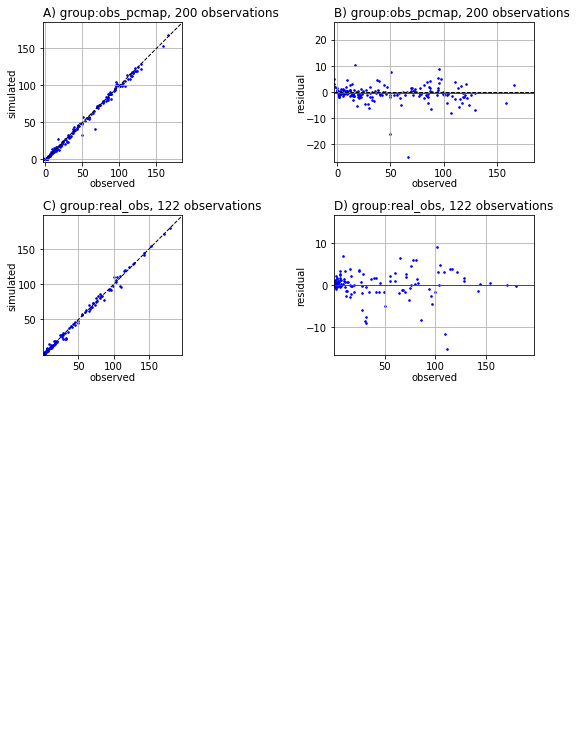

In [6]:
pst.plot(kind='1to1')

In [7]:
pst.control_data.noptmax = 7 # number of iterations (should be set to a great value (50))
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 4
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case)
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case)
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:7, npar_adj:133, nnz_obs:322


In [33]:
# DO the inversion
# m_d = "master_glm_run"
# pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=10,worker_root=".",
#                              master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

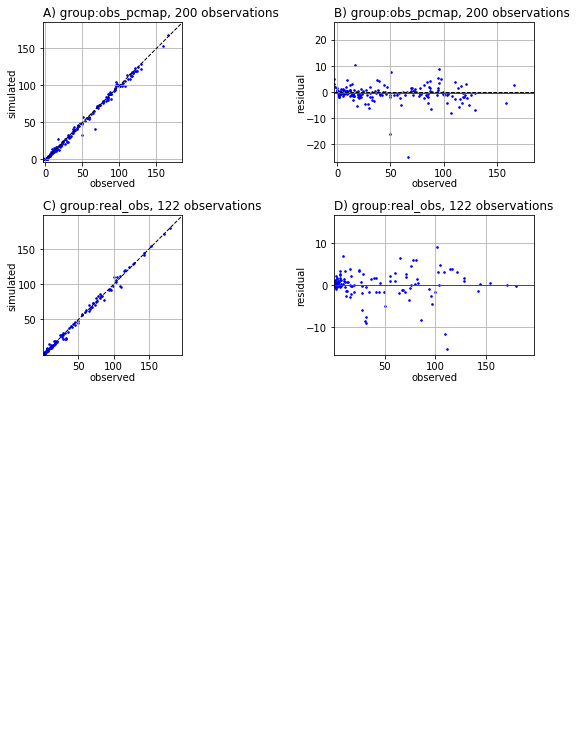

In [8]:
m_d = "master_glm_run"
pst_2 = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_2.plot(kind="1to1")

3325.0266588338473 {'obs_pcmap': 2012.4955112103642, 'real_obs': 1312.5311476234833} {'obs_pcmap': 0.6052569551175226, 'real_obs': 0.3947430448824774}


[None,
 None,

<Figure size 576x756 with 0 Axes>

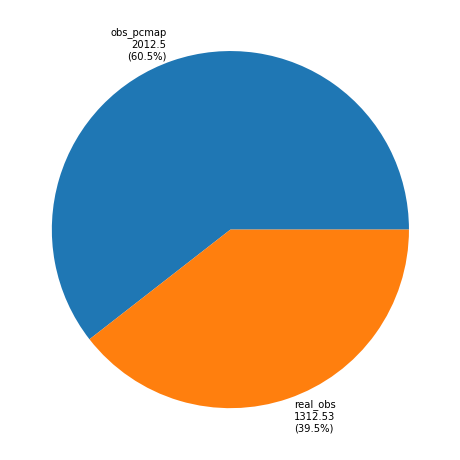

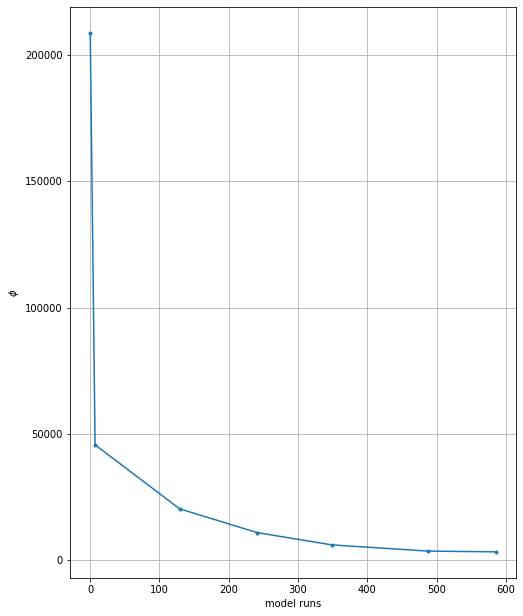

In [9]:
pst_2.plot()

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pyemu\en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


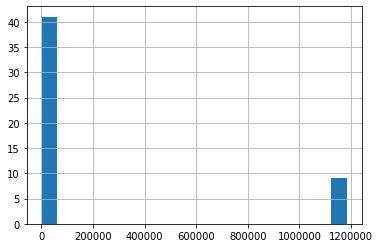

In [10]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

ax = oe.phi_vector.hist(bins=20)

In [14]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
dfp.head()

prior_mean  prior_stdev  prior_lower_bound  \
name                                                               
KP_INST:0_I:31_J:121         0.0     0.337744          -0.675488   
KP_INST:0_I:40_J:112         0.0     0.337744          -0.675488   
KP_INST:0_I:40_J:121         0.0     0.337744          -0.675488   
KP_INST:0_I:49_J:103         0.0     0.337744          -0.675488   
KP_INST:0_I:49_J:112         0.0     0.337744          -0.675488   

                      prior_upper_bound  post_mean  post_stdev  \
name                                                             
KP_INST:0_I:31_J:121           0.675488   0.476587    0.300225   
KP_INST:0_I:40_J:112           0.675488  -1.301030    0.144608   
KP_INST:0_I:40_J:121           0.675488  -1.301030    0.272330   
KP_INST:0_I:49_J:103           0.675488   0.717481    0.043544   
KP_INST:0_I:49_J:112           0.675488   0.647928    0.167127   

                      post_lower_bound  post_upper_bound  
name                                                      
KP_INST:0_I:31_J:121         -0.123864          1.077040  
KP_INST:0_I:40_J:112         -1.590250         -1.011810  
KP_INST:0_I:40_J:121         -1.845690         -0.756370  
KP_INST:0_I:49_J:103          0.630392          0.804569  
KP_INST:0_I:49_J:112          0.313674          0.982181

[Text(0.5, 1.0, 'Post standard deviation distribution (multiplier)')]

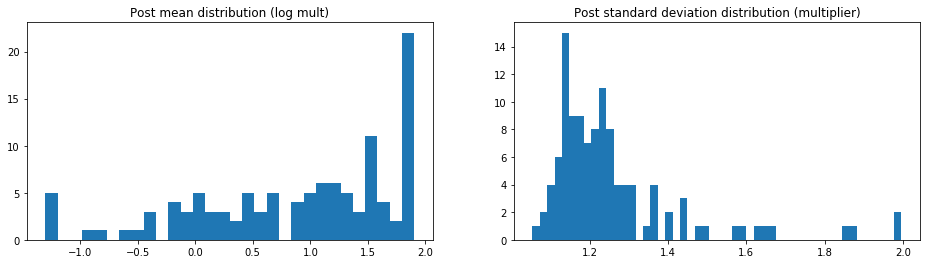

In [98]:
idx = [i for i in dfp.index if "KP" in i]
fig,ax=plt.subplots(1,2,figsize=(16,4))

ax[0].hist(dfp.loc[idx]["post_mean"],bins=30)
ax[0].set(title="Post mean distribution (log mult)")
ax[1].hist(10**dfp.loc[idx]["post_stdev"],bins=50)
ax[1].set(title="Post standard deviation distribution (multiplier)")

In [64]:
#kriging standard dev
pst_2.parameter_data.parval1 = 10**dfp["post_stdev"].values
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kstd = np.loadtxt(os.path.join(t_d,"k.txt"))
kstd[kstd == kstd[0,0]] = None

#kriging kmax
pst_2.parameter_data.parval1 = 10**dfp["post_upper_bound"].values
pst_2.control_data.noptmax = 0 # one run
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kmax = np.loadtxt(os.path.join(t_d,"k.txt"))
kmax[np.isnan(kstd)] = None

#kriging kmin
pst_2.parameter_data.parval1 = 10**dfp["post_lower_bound"].values
pst_2.control_data.noptmax = 0 # one run
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kmin = np.loadtxt(os.path.join(t_d,"k.txt"))
kmin[np.isnan(kstd)] = None

#kriging k to plot
pst_2.parameter_data.parval1 = 10**dfp["post_mean"].values
pst_2.control_data.noptmax = 0 # one run
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)

k = np.log10(np.loadtxt(os.path.join(t_d,"k.txt")))
k[np.isnan(kstd)] = None

noptmax:0, npar_adj:133, nnz_obs:322
noptmax:0, npar_adj:133, nnz_obs:322
noptmax:0, npar_adj:133, nnz_obs:322
noptmax:0, npar_adj:133, nnz_obs:322


[Text(0.5, 1.0, 'Kmin log')]

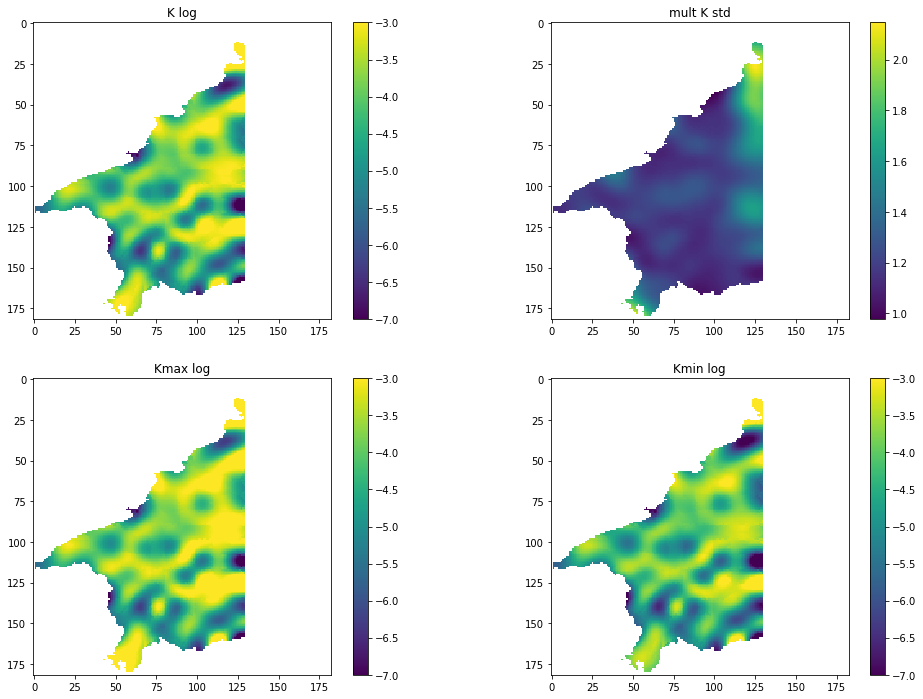

In [102]:
# inversion
fig,ax = plt.subplots(2,2,figsize=(17,12))
a1 = ax[0,0].imshow(k)
fig.colorbar(a1,ax=ax[0,0])
ax[0,0].set(title="K log")

a2 = ax[0,1].imshow(kstd/1e-5)
fig.colorbar(a2,ax=ax[0,1])
ax[0,1].set(title="mult K std")

a3 = ax[1,0].imshow(np.log10(kmax))
fig.colorbar(a3,ax=ax[1,0])
ax[1,0].set(title="Kmax log")

a4 = ax[1,1].imshow(np.log10(kmin))
fig.colorbar(a4,ax=ax[1,1])
ax[1,1].set(title="Kmin log")

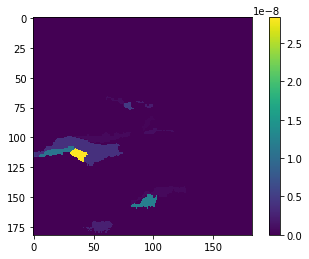

In [105]:
plt.imshow((np.loadtxt(os.path.join(t_d,"irr.txt"))))
plt.colorbar()

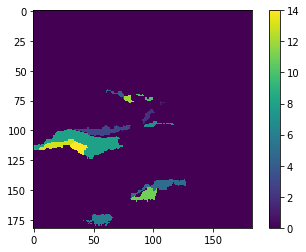

In [74]:
plt.imshow((np.loadtxt(os.path.join(t_d,"zone_irr.txt"))))
plt.colorbar()

In [18]:
m_n_i = "pest_2d_r"
sim = fp.mf6.MFSimulation.load(sim_ws="workspace")
m = sim.get_model(m_n_i)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package obs...
    loading package npf...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
  loading ims package pest_2d_r...


In [26]:
grid = m.modelgrid
pz="../../../data/cartes_pz/Piézo_Pliocène_1990_V2.grd"
rast = Raster.load(pz)
Mes_pz = rast.resample_to_grid(grid.xcellcenters,grid.ycellcenters,1)

In [35]:
riv_files = [os.path.splitext(riv)[0] for riv in os.listdir("workspace") if riv.endswith(".riv")]

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


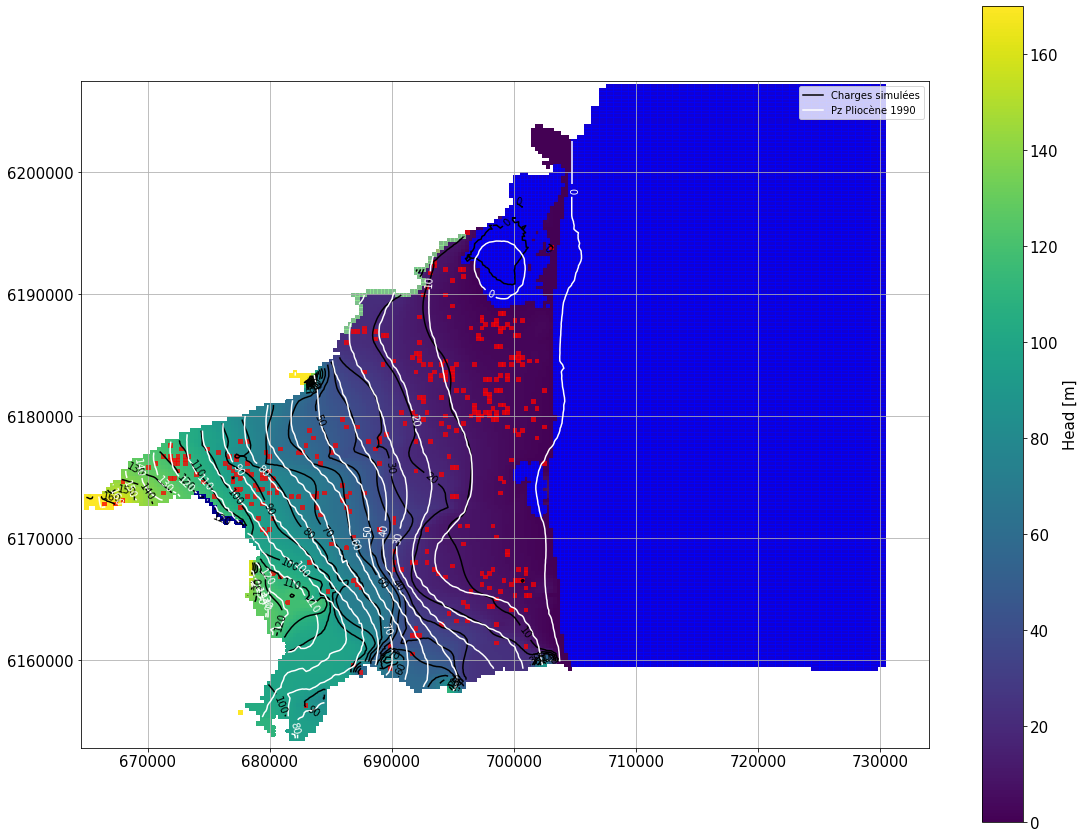

In [50]:

head = get_heads("pest_2D_R",t_d)

# initialize plot
fig = plt.figure(figsize=(19,15))
layer = 0
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=layer)

#plot heads
hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),colors='black')
plt.clabel(cont,fmt="%1i")

##cont des mesures piézométriques
Mes_pz[[head[layer]==1e30]]=None
cont_2=ml.contour_array(Mes_pz,levels=np.linspace(0,170,18),colors='white')
plt.clabel(cont_2,fmt="%1i")

#legend
proxy = [plt.Line2D((0,1),(0,0),color="black"),plt.Line2D((0,1),(0,0),color="white")]
plt.legend(proxy,["Charges simulées","Pz Pliocène 1990"])

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5)
for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("wel",alpha=0.5)
ml.plot_bc("Corb",color="lightgreen",alpha=0.5)
ml.plot_bc("thuir",color="darkblue",alpha=1)

ax.tick_params(labelsize=15)

#colorbar
g = plt.colorbar(hmesh)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

In [106]:
def mae(x):
    return np.sum(np.abs(x))/x.shape[0]
x = pst_2.res.residual.values
mae(x)

1.9097190555036085